# Práctica 1.1: MÉTODOS AVANZADOS DE PREPROCESADO DE IMAGEN MÉDICA (filtrado NLM)

Índice de los pasos a seguir:
1. Preparación de imágenes y adición de ruido
2. Filtrado NLM
3. Filtrado NLM samepatch comparison 
4. Filtrado NLM-CPP 
5. Resultados
6. Referencias

## Adición de ruido

En esta sección vamos a proceder a añadir ruido a las imágenes que hemos obtenido del repositorio de bases de datos Open Neuro, para poder evaluar los resultados de filtrado que debemos realizar. 

En primer lugar, cargaremos las imágenes con las que testearemos nuestro código. Se trata de imágenes de fMRI.

In [1]:
import os
import numpy as np #popular library for scientific computing
import nibabel as nib
import matplotlib #plotting library compatible with numpy
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
import modules
import funciones
from nilearn import plotting
#import scipy.ndimage.filters as filters

In [2]:
img1 = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-01\anat\sub-01_T1w.nii.gz')
img2 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-17\anat\sub-17_T1w.nii.gz")
img3 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-26\anat\sub-26_T1w.nii.gz")
img4 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-31\anat\sub-31_T1w.nii.gz")
img5 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-13\anat\sub-13_T1w.nii.gz")
img6 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-15\anat\sub-15_T1w.nii.gz")

In [3]:
print (img1)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (176, 256, 256)
affine: 
[[ 9.96775329e-01 -1.48763147e-03 -8.02301541e-02 -8.26823959e+01]
 [-2.98805232e-03  9.98446643e-01 -5.56366481e-02 -1.06932190e+02]
 [ 8.01882967e-02  5.56969717e-02  9.95222449e-01 -1.48407990e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.  1.  1.  2.4 0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice

Vamos a estudiar algunas características de los datos que hemos cargado, además de mostrarlos por pantalla.

In [4]:
data = img1.get_fdata()  

In [5]:
print(data.shape)

(176, 256, 256)


In [6]:
print(data.dtype, img1.get_data_dtype())

float64 float32


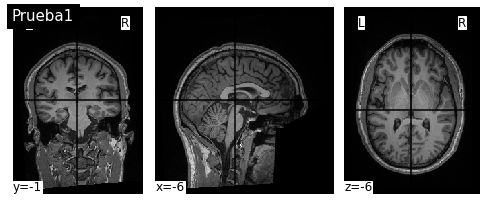

In [7]:
plotting.plot_img(img1, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()                

Para poder añadirle el ruido a las imágenes, vamos a transformar los datos al formato array, y tras ello guardaremos un único corte (que hemos elegido de manera aleatoria) al que realizaremos la adición. 

> En caso de querer disminuir el tiempo de ejecución descomente una de las líneas para disminuír el tamaño de las imágenes y por ende, el número de píxeles a analizar.<pre><code>a = np.array(skimage.transform.resize(img1.dataobj, (50,70)))
a = np.array(skimage.transform.rescale(img.dataobj,0.3))
</code></pre> Y comente la línea:<pre><code>a = np.array(img1.dataobj)
</code></pre>

In [8]:
#Vamos a probar los algoritmos con imágenes más pequeñas para disminuir el tiempo de computación
a = np.array(skimage.transform.resize(img1.dataobj, (100,140)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape

(100, 140, 256)

Una resonancia obtiene imagenes en 3D, por lo que a la hora de analizar el array obtenido, debemos tener en cuenta que las tres posiciones que obtenemos corresponden a:
1. La altura de la imagen.
2. El ancho de la imagen.
3. El número de corte.

Para poder analizar las imágenes, escogeremos un corte intermedio (128).

Normalizaremos las frecuencias de las imágenes, de forma que el rango de este nuevo histograma sea [0,1] Es decir dividimos cada frecuencia entre el total de píxeles de la imagen.


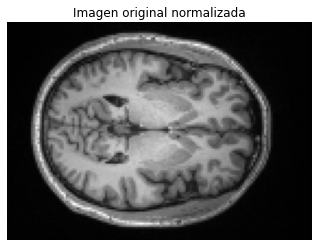

In [9]:
img_gray= a[:,:,128]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)

Llamando a la función **.add_gnoise()** y la función **.salpimienta** del módulo modules.py que hemos creado, conseguimos añadir ruido gaussiano e impulsivo a la imagen. 

C:\Users\nakag\OneDrive\Escritorio\IMagen\FormatoEntrega\modules.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=1
C:\Users\nakag\OneDrive\Escritorio\IMagen\FormatoEntrega\modules.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=0


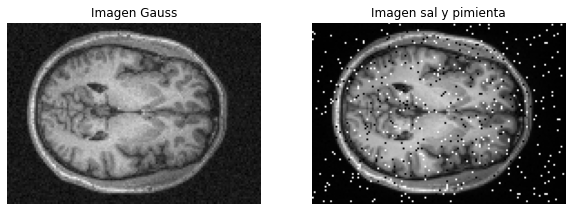

In [10]:
#Aplicar ruido gaussiano
img_gauss=modules.add_gnoise(img_o,0.03)

#Aplicar ruido impulsivo
img_salpimienta=modules.salpimienta(img_o,0.05)

fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Imagen Gauss'), plt.axis('off')
plt.subplot(122)
plt.title('Imagen sal y pimienta'), plt.axis('off')
plt.imshow(img_salpimienta, cmap=plt.cm.gray)


Hemos creado una función para agilizar el procedimiento anterior con todas las imágenes, **image_prep(img)**, que será la encargada de preparar y normalizar nuestras imágenes siguiendo los pasos indicados en celdas anteriores.

A continuación obtenemos un conjunto de imágenes ruidosas de **diferentes tipos de ruido e intensidades** para probar los algoritmos con algunas de ellas:

In [11]:
img_o2 = funciones.image_prep(img2)
img_gauss2=modules.add_gnoise(img_o2,0.03)
img_salpimienta2=modules.salpimienta(img_o2,0.05)
img_o3 = funciones.image_prep(img3)
img_gauss3=modules.add_gnoise(img_o3,0.07)
img_salpimienta3=modules.salpimienta(img_o3,0.1)
img_o4 = funciones.image_prep(img4)
img_gauss4=modules.add_gnoise(img_o4,0.1)
img_salpimienta4=modules.salpimienta(img_o4,0.15)
img_o5 = funciones.image_prep(img5)
img_gauss5=modules.add_gnoise(img_o5,0.15)
img_salpimienta5=modules.salpimienta(img_o5,0.2)
img_o6 = funciones.image_prep(img6)
img_gauss6=modules.add_gnoise(img_o6,0.2)
img_salpimienta6=modules.salpimienta(img_o6,0.25)

Representamos algunas de las imágenes para comprobar que, efectivamente, se está haciendo la ***correcta adición de ruido y en intensidades crecientes***.

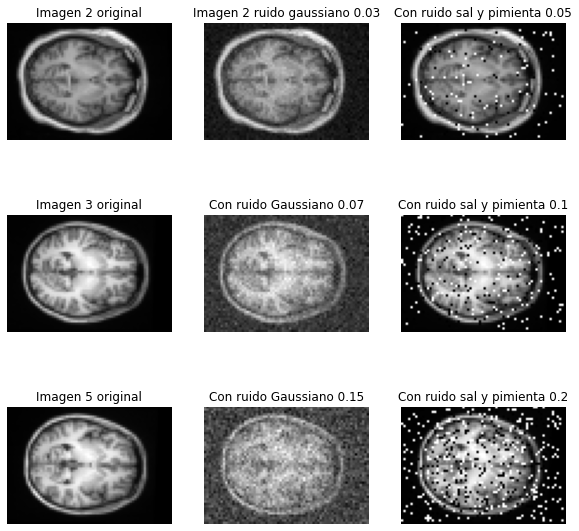

In [12]:
fig = plt.figure(figsize=(10,10))
plt.subplot(331)
plt.imshow(img_o2,cmap=plt.cm.gray)
plt.title('Imagen 2 original'), plt.axis('off')
plt.subplot(332)
plt.title('Imagen 2 ruido gaussiano 0.03'), plt.axis('off')
plt.imshow(img_gauss2, cmap=plt.cm.gray)
plt.subplot(333)
plt.imshow(img_salpimienta2,cmap=plt.cm.gray)
plt.title('Con ruido sal y pimienta 0.05'), plt.axis('off')
plt.subplot(334)
plt.title('Imagen 3 original'), plt.axis('off')
plt.imshow(img_o3, cmap=plt.cm.gray)
plt.subplot(335)
plt.imshow(img_gauss3,cmap=plt.cm.gray)
plt.title('Con ruido Gaussiano 0.07'), plt.axis('off')
plt.subplot(336)
plt.title('Con ruido sal y pimienta 0.1'), plt.axis('off')
plt.imshow(img_salpimienta3, cmap=plt.cm.gray)
plt.subplot(337)
plt.imshow(img_o5,cmap=plt.cm.gray)
plt.title('Imagen 5 original'), plt.axis('off')
plt.subplot(338)
plt.title('Con ruido Gaussiano 0.15'), plt.axis('off')
plt.imshow(img_gauss5, cmap=plt.cm.gray)
plt.subplot(339)
plt.title('Con ruido sal y pimienta 0.2'), plt.axis('off')
plt.imshow(img_salpimienta5, cmap=plt.cm.gray)


## Filtrado Non-Local Means

En este apartado vamos a mostrar los resultados de realizar un filtrado NLM en algunas de las imágenes. Debemos saber que el **filtrado Non-Local Means** consiste en filtrar la imagen mediante un promedio ponderado de los diferentes píxeles de la imagen en función de su similitud con el pixel original. Es decir, vamos a ir buscando a lo largo de la imagen píxeles que sean similares al pixel particular que quiero filtrar, para así darle mucho más peso a aquellos que tengan mayor similitud al original.

Es decir, el valor para un píxel matemáticamente hablando se calcula como:

\begin{equation*}
NL[v](i)= \sum_{j\in I} w(i,j)v(j)
\end{equation*}

donde ***w(i,j)*** depende de la similitud entre el pixel a filtrar ***v(i)*** y el píxel con el que estoy comparando ***v(j)***.

***
>La hipótesis que vamos a asumir es que nuestro píxel debe ser similar a píxeles similares, pero no necesariamente a sus vecinos.
***

Para ello hemos creado la función **.nlm(img_ori, h_square)** en el archivo modules.py. En esta función tenemos en cuenta dos parámetros:
* img_ori: que hace referencia a la imagen ruidosa que queremos filtrar. 
* h_square: se trata del parámetro de similitud asociado al **grado de filtrado** que queremos aplicar.

Para programar este filtro debemos tener en cuenta el flujo que vamos a seguir:

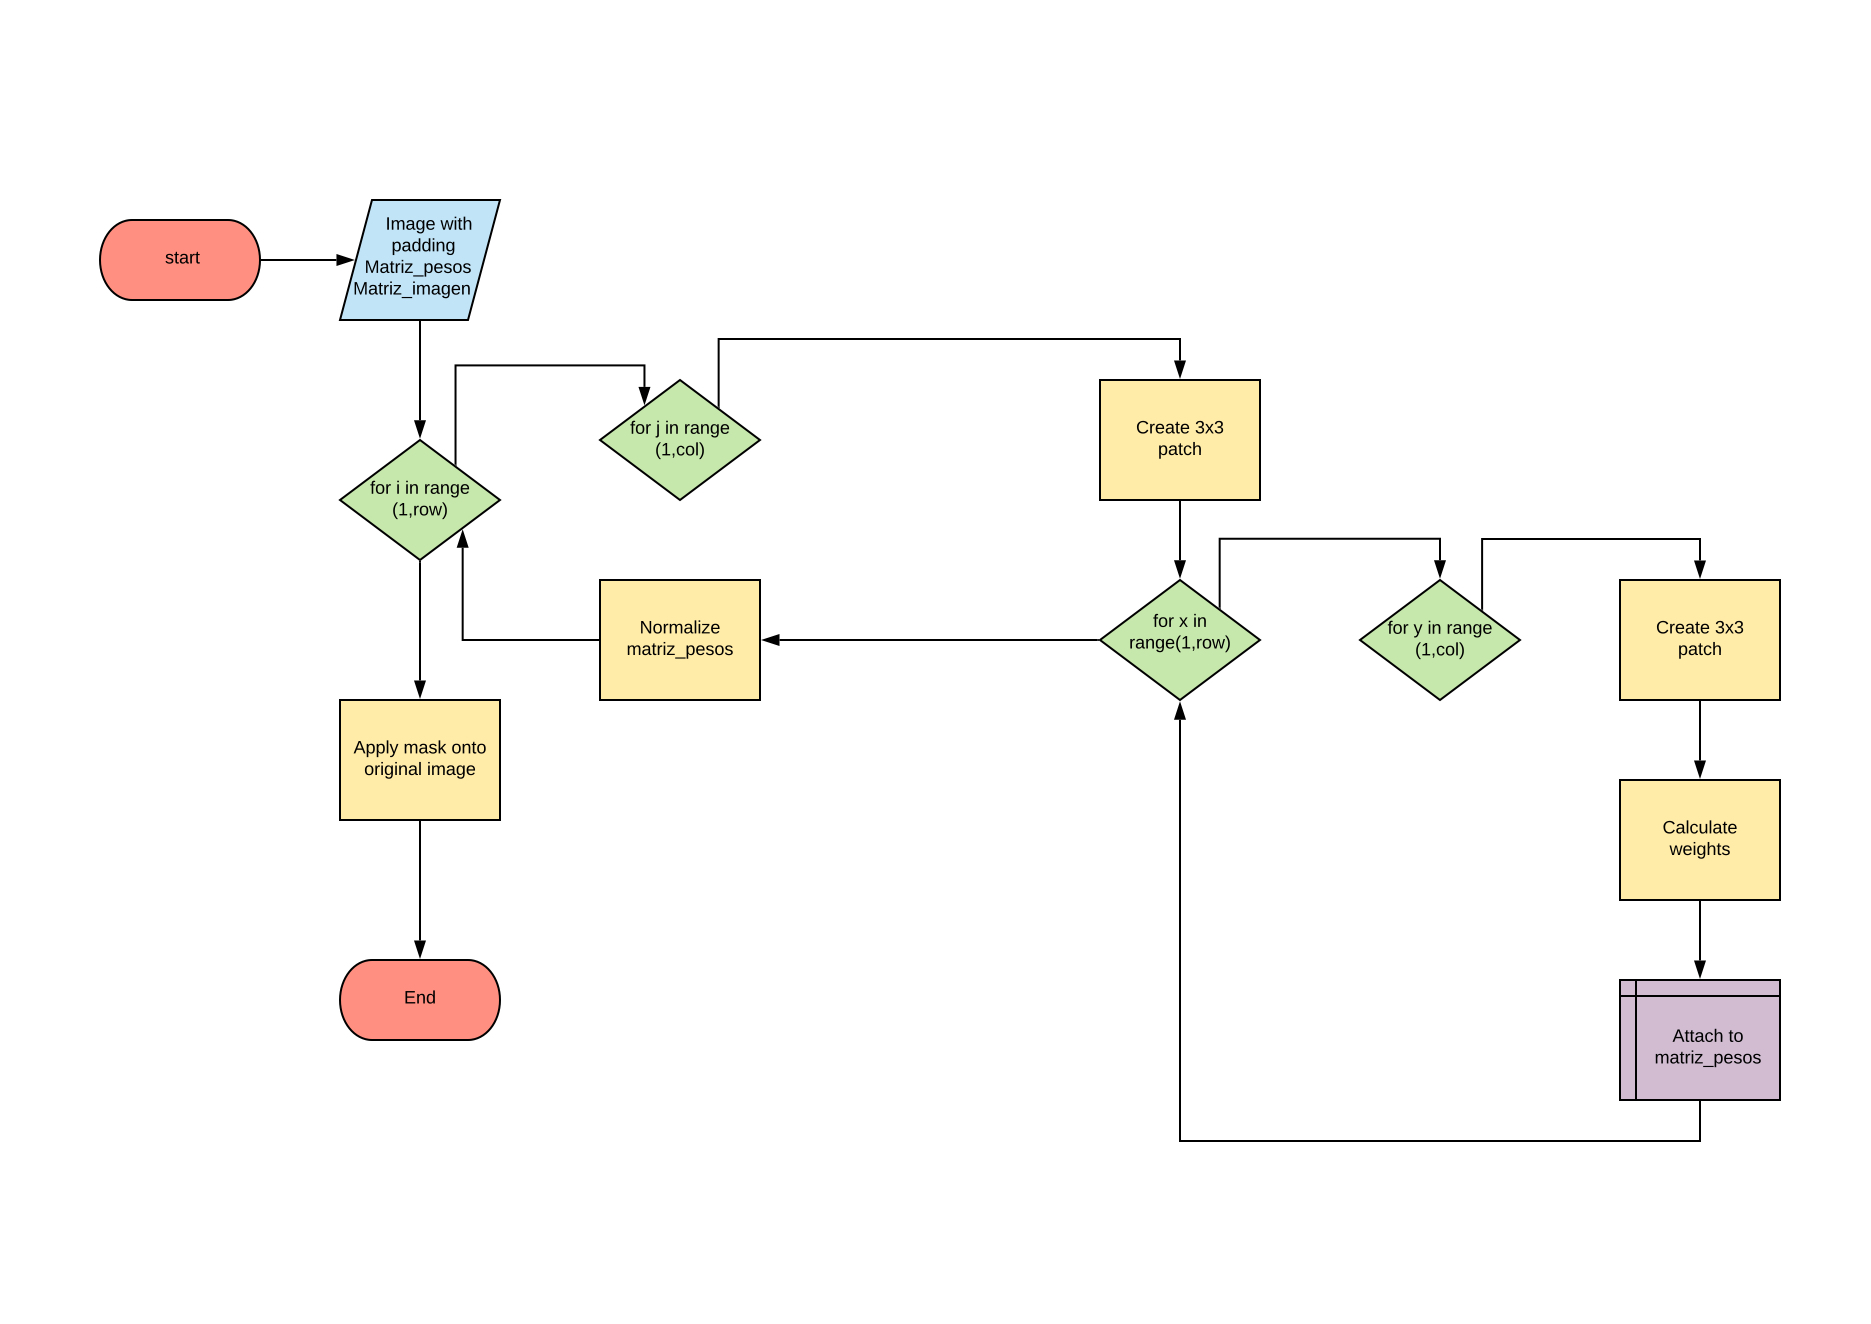

En resumen, el procedimiento es el siguiente:
1. Definimos el cálculo de los pesos ***w(i,j)***:
\begin{equation*}
w(i,j) = \frac{1}{Z(i)}e^{- \frac{d(i,j)}{h^2}}
\end{equation*}
donde $h^2$ es un parámetro de similitud asociado al grado de filtrado.

2. $d(i,j)$ es la distancia euclídea entre los píxeles de un parche centrado en $v(i)$ y los de otro centrado en $v(j)$.
3. Finalmente debemos tener en cuenta que $Z(i)$ en el punto 1 hace referencia a la constante de normalización, y se define como la suma de todos los pesos.

Debemos tener en cuenta que al estar normalizando las imágenes por el máximo argumento de la matriz inicial, el valor $h_2$ debe oscilar en el rango [0, 1] en función de la cantidad de ruido. Esto lo discutiremos en las celdas siguientes.

In [13]:
img_pad = np.pad(img_gauss,1, mode='reflect')
matriz_imagen1 = modules.nlm(img_gauss,img_pad, 0.4)

img_pad = np.pad(img_gauss6,1, mode='reflect')
matriz_imagen2 = modules.nlm(img_gauss6,img_pad, 0.9)

Comparemos las imagenes ruidosas originales (en este caso con un ruido gaussiano) con las imagenes filtradas con nuestro algoritmo:

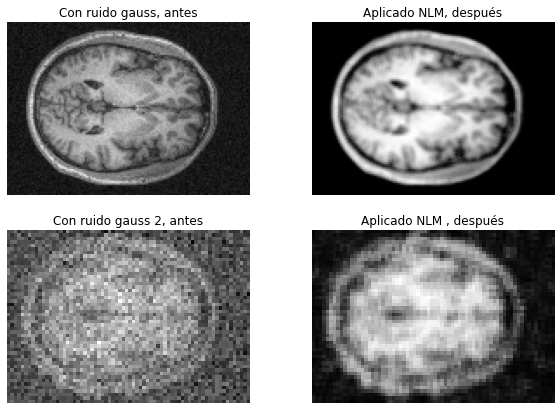

In [14]:
fig = plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Con ruido gauss, antes'), plt.axis('off')
plt.subplot(222)
plt.title('Aplicado NLM, después'), plt.axis('off')
plt.imshow(matriz_imagen1, cmap=plt.cm.gray)
plt.subplot(223)
plt.imshow(img_gauss6,cmap=plt.cm.gray)
plt.title('Con ruido gauss 2, antes'), plt.axis('off')
plt.subplot(224)
plt.title('Aplicado NLM , después'), plt.axis('off')
plt.imshow(matriz_imagen2, cmap=plt.cm.gray)

Como podemos ver en la anterior comparativa, este algoritmo es bastante competitivo incluso en imágenes muy ruidosas, ya que vemos una mejora considerable en la recuperación de bordes.

Realizamos igualmente una comparación con imágenes con ruido sal y pimienta. Se debe destacar la **importancia del parámetro de filtrado h2**, ya que a mayor ruido mejoraremos la calidad de nuestro filtrado disminuyendo dicho filtrado. Pero, ¿a qué se debe esto? Observemos la parte exponencial de la ecuación que utilizamos a la hora de calcular los pesos:
\begin{equation*}
e^{- \frac{d(i,j)}{h^2}}
\end{equation*}
Como vemos, cuanto mayor sea el parámetro $h^2$, mayor será el exponente de la exponencial y por ende, como resultado obtendremos un número más pequeño. Esto se traduce en que el peso por el que vamos a ponderar nuestro píxel objetivo va a ser menor. 

Por ello, podríamos concluir que el parámetro óptimo dependerá de la cantidad de ruido de nuestra imagen (proporcional a la desviación estándar de dicho ruido).

En resumen, cuando tenemos una imagen con poco ruido no necesitaremos un valor de $h_2$ muy alto. Sin embargo, para que nuestro filtro consiga procesar correctamente una imagen muy ruidosa necesitaremos que el peso asignado sea mayor y por ende, un $h_2$ proporcional.

In [15]:
img_pad = np.pad(img_salpimienta,1, mode='reflect')
matriz_imagen3 = modules.nlm(img_salpimienta,img_pad, 0.4)

img_pad = np.pad(img_salpimienta6,1, mode='reflect')
matriz_imagen4 = modules.nlm(img_salpimienta6,img_pad, 0.9)

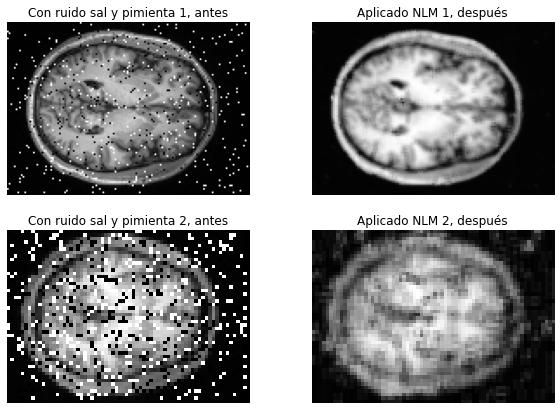

In [16]:
fig = plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(img_salpimienta,cmap=plt.cm.gray)
plt.title('Con ruido sal y pimienta 1, antes'), plt.axis('off')
plt.subplot(222)
plt.title('Aplicado NLM 1, después'), plt.axis('off')
plt.imshow(matriz_imagen3, cmap=plt.cm.gray)
plt.subplot(223)
plt.imshow(img_salpimienta6,cmap=plt.cm.gray)
plt.title('Con ruido sal y pimienta 2, antes'), plt.axis('off')
plt.subplot(224)
plt.title('Aplicado NLM 2, después'), plt.axis('off')
plt.imshow(matriz_imagen4, cmap=plt.cm.gray)

Con imágenes con ruido impulsivo obtenemos un resultado bastante satisfactorio como en el caso anterior.

Comparando la imagen filtrada con NLM con la imagen procesada con **filtros suavizantes estándar**, podemos observar varias cosas:
* Con el algoritmo NLM vemos un suavizado mucho más específico y una definición mucho mayor de los bordes.
* Cuando observamos los filtros suavizantes estándar, vemos que estamos asumiendo que cuando filtramos un determinado píxel, sus vecinos son iguales a dicho píxel pero que las diferencias se deben al ruido. Esto no sería correcto en imágenes **no** homogéneas, ya que las diferencias no se corresponden a ruido sino a bordes y estructuras.


(Text(0.5, 1.0, 'Gaussian filtered image'), (-0.5, 139.5, 99.5, -0.5))

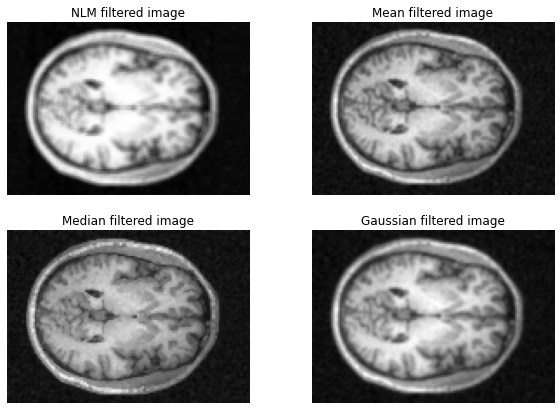

In [17]:
img_pad = np.pad(img_gauss,1, mode='reflect')
matriz_imagen1 = modules.nlm(img_gauss,img_pad, 80)
img_meanfiltered = modules.mean_filter(img_gauss,2)
img_gaussianfiltered = modules.gaussian_filter(img_gauss,0.75)
img_medianfiltered = modules.median_filter(img_gauss,2)


fig = plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(matriz_imagen1, cmap=plt.cm.gray)
plt.title('NLM filtered image'), plt.axis('off')
plt.subplot(222)
plt.imshow(img_meanfiltered, cmap=plt.cm.gray)
plt.title('Mean filtered image'), plt.axis('off')
plt.subplot(223)
plt.imshow(img_medianfiltered, cmap=plt.cm.gray)
plt.title('Median filtered image'), plt.axis('off')
plt.subplot(224)
plt.imshow(img_gaussianfiltered, cmap=plt.cm.gray)
plt.title('Gaussian filtered image'), plt.axis('off')
  

Como vemos, incluso el algoritmo NLM simple que hemos creado puede competir con los filtros derivativos del paquete **scipy.ndimage.filters()**. Sin embargo, a continuación vamos a realizar algunas mejoras.

## Modificaciones de NLM: Comparación con el mismo parche

Uno de los problemas que encontramos al aplicar NLM es que, iterando sobre todos los píxeles de la imagen, acabamos comparando el parche original consigo mismo. 
***
Para solucionar esto tenemos dos alternativas:
* Eliminar el parche original de la búsqueda.
* Ponderando el parche original utilizando el **valor máximo de similitud** que se haya encontrado en el resto de la imagen.
\begin{equation*}
w(i,j) = max(w(i,j)\forall j\neq i)
\end{equation*}
***
Nosotras vamos a implemantar la segunda alternativa a continuación.

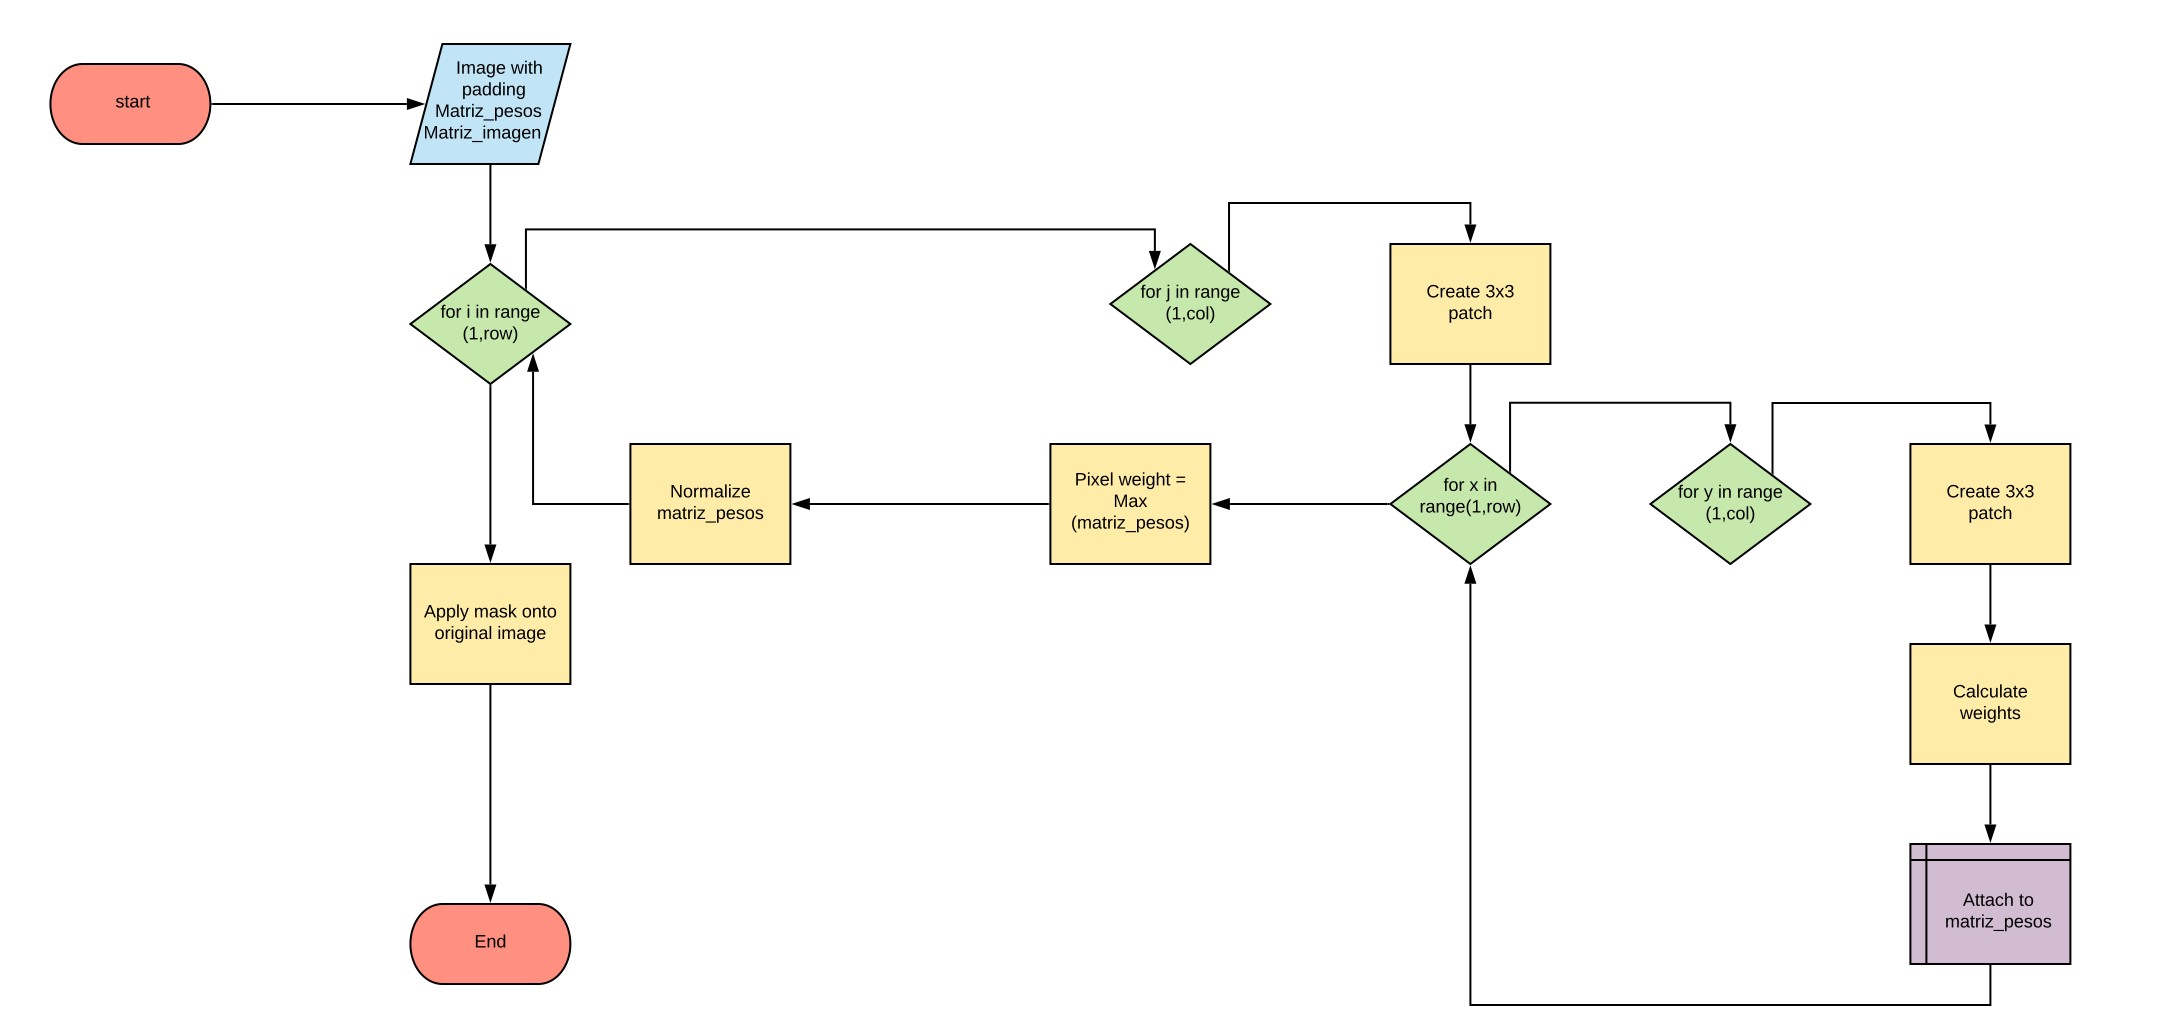

Como hemos hecho anteriormente vamos a filtrar las imágenes, esta vez con la función **.nlm_samepatch()** de **modules.py**.  

In [18]:
img_pad = np.pad(img_gauss,1, mode='reflect')
nlm_samepatch = modules.nlm_samepatch(img_gauss,img_pad, 0.4)

img_pad = np.pad(img_salpimienta4,1, mode='reflect')
nlm_samepatch2 = modules.nlm_samepatch(img_salpimienta4,img_pad, 2)

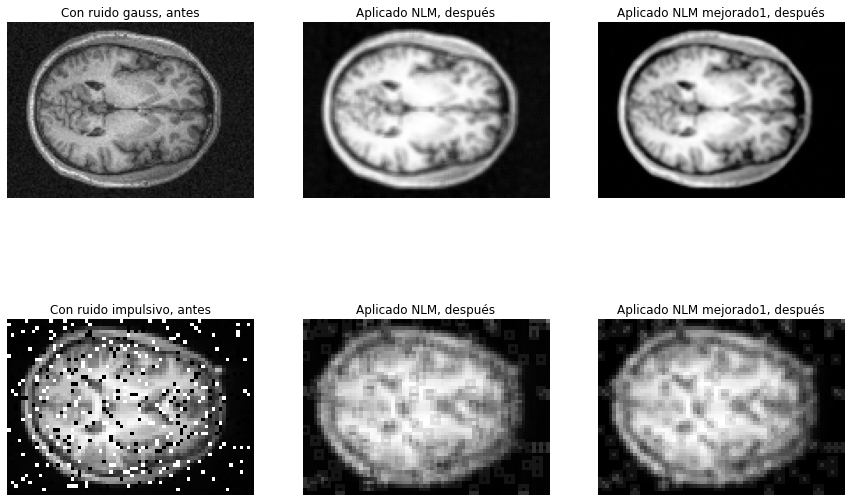

In [19]:
img_pad = np.pad(img_salpimienta4,1, mode='reflect')
matriz_imagen5 = modules.nlm(img_salpimienta4,img_pad, 2)

fig = plt.figure(figsize=(15,10))
plt.subplot(231)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Con ruido gauss, antes'), plt.axis('off')
plt.subplot(232)
plt.title('Aplicado NLM, después'), plt.axis('off')
plt.imshow(matriz_imagen1, cmap=plt.cm.gray)
plt.subplot(233)
plt.title('Aplicado NLM mejorado1, después'), plt.axis('off')
plt.imshow(nlm_samepatch, cmap=plt.cm.gray)
plt.subplot(234)
plt.imshow(img_salpimienta4,cmap=plt.cm.gray)
plt.title('Con ruido impulsivo, antes'), plt.axis('off')
plt.subplot(235)
plt.title('Aplicado NLM, después'), plt.axis('off')
plt.imshow(matriz_imagen5, cmap=plt.cm.gray)
plt.subplot(236)
plt.title('Aplicado NLM mejorado1, después'), plt.axis('off')
plt.imshow(nlm_samepatch2, cmap=plt.cm.gray)

Como vemos, **no se aprecia una diferencia significativa entre los algoritmos**. Esto se debe a que realmente la modificación que estamos realizando es únicamente un pequeño cambio en las ponderaciones. 

## Modificaciones de NLM: NLM-CPP

Para solventar el problema que se nos presenta al aplicar el filtro NLM sobre un píxel que es muy diferente a los píxeles de su entorno, vamos a programar lo que se llama **NLM-CPP**. 
>Este filtro consigue evitar un suavizado excesivo de los puntos brillantes, utilizando para ello un sistema de ponderado sobre los pesos originales $w(i,j)$ del NLM sencillo, para que de esta manera, dependan de la **similitud de los píxeles centrales**.

\begin{equation*}
w(i,j)^{CPP} = \eta(i,j)w(i,j)\forall j\neq i
\end{equation*}
donde
\begin{equation*}
\eta(i,j) = \frac{1}{1+(\lbrack|v(i)-v(j)|/D_0\rbrack)^{2\alpha}}
\end{equation*}
***

Donde $\eta(i,j)$ denota la similitud que está definida como una función decreciente de diferencia en intensidad $|v(i)-v(j)|$ que asigna pesos más altos a píxeles cuyas intensidades se parecen más al píxel central. 

Los parámetros $D_0$ y $\alpha$ controlan la posición y la pendiente respectivamente. 

Debemos tener en cuenta que esta variable $\eta(i,j)$ tiene un rango de entre 0 y 1, y que si el valor se aproxima a 0 significa que la intensidad del píxel j es significativamente diferente al píxel i central. Según las ecuaciones superiores, **solo si la similitud entre los parches y los píxeles centrales es alta simultáneamente se les asignará un peso grande en magnitud en el filtrado**.

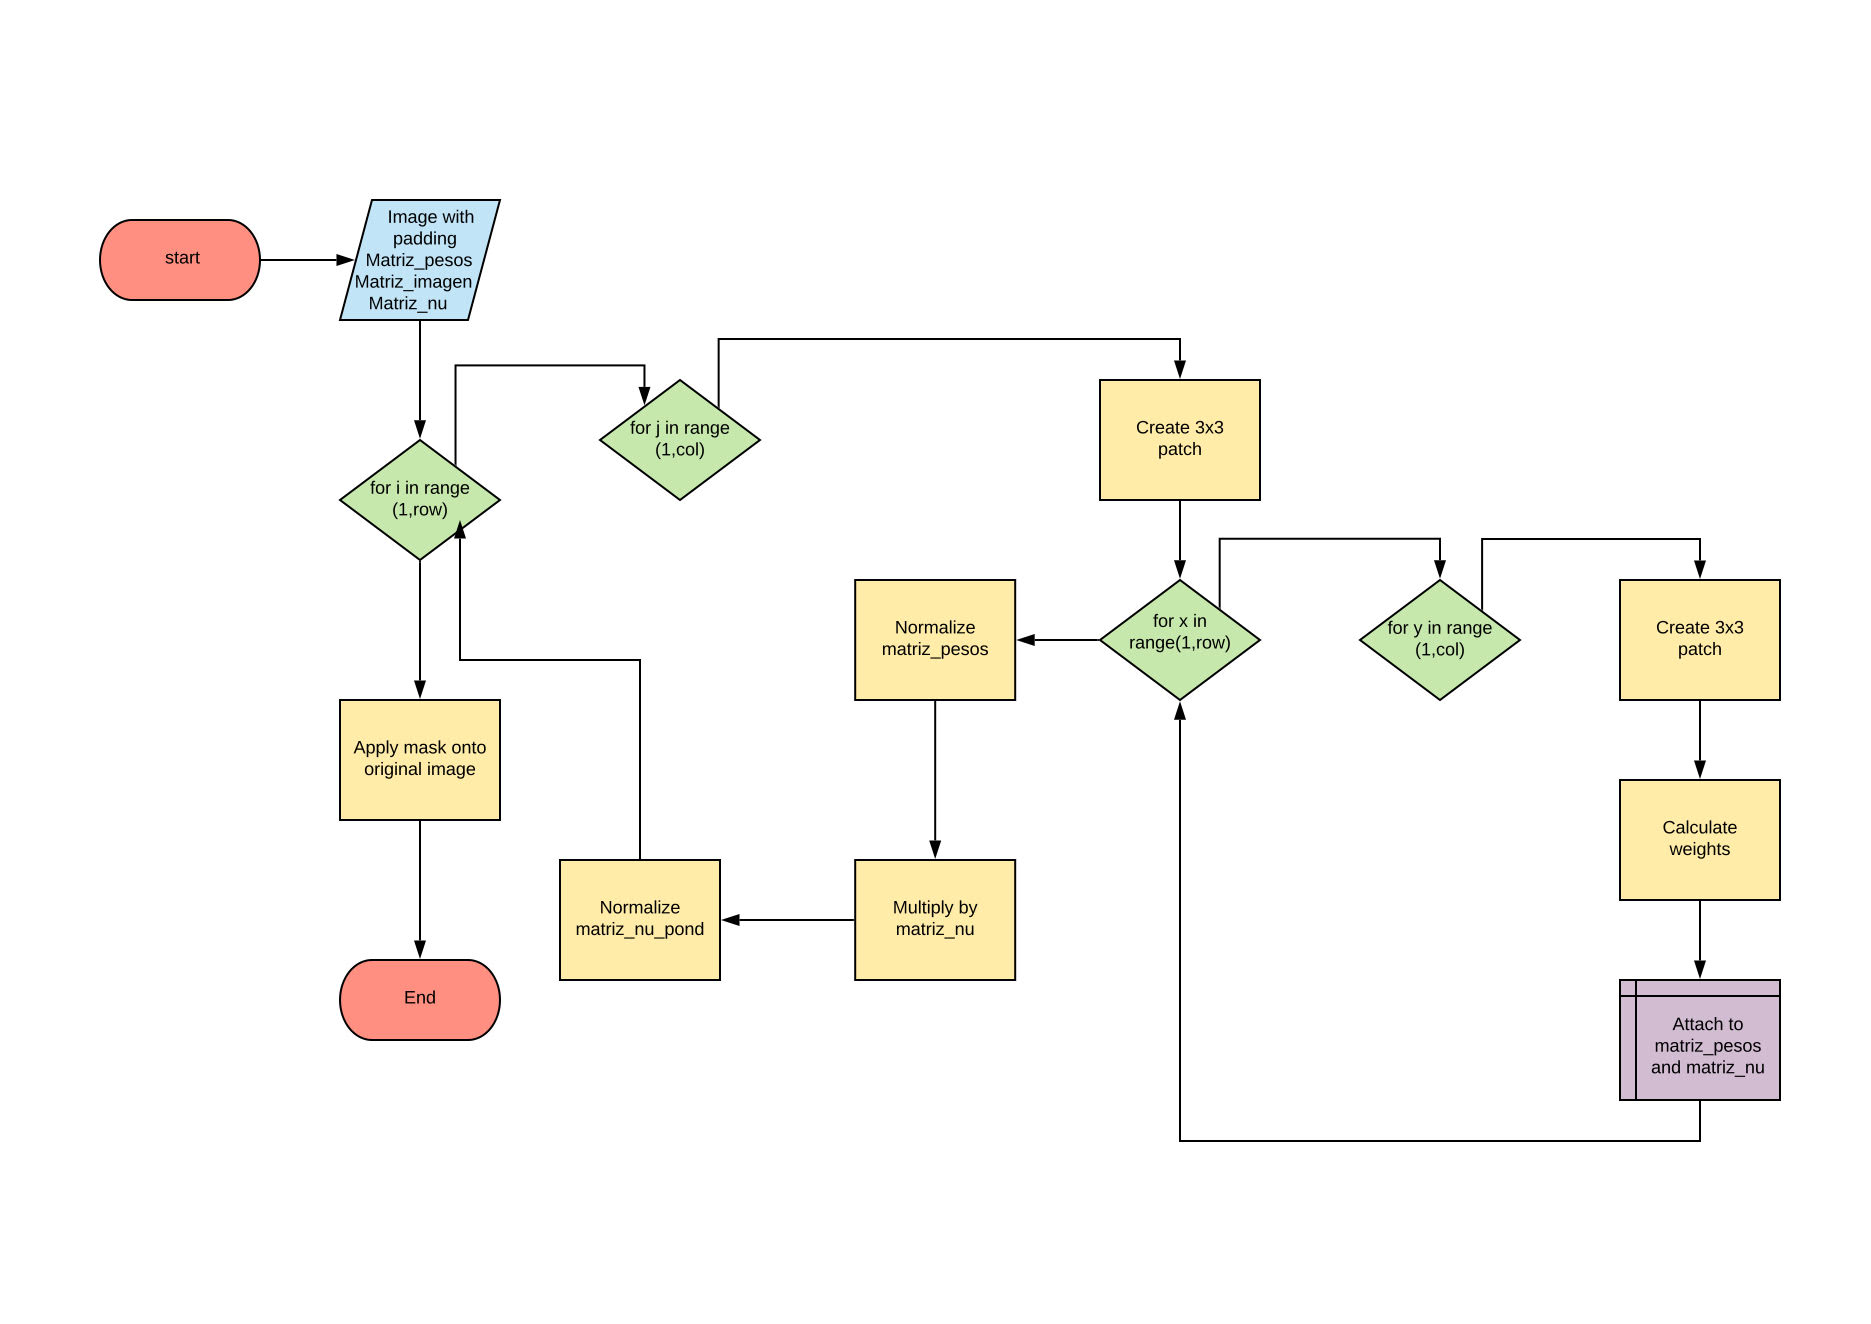

In [20]:
nlm_sal, sp_sal, nlm_cpp1 = funciones.all_filters(img_salpimienta, 5, 5, 5, 10, 10)

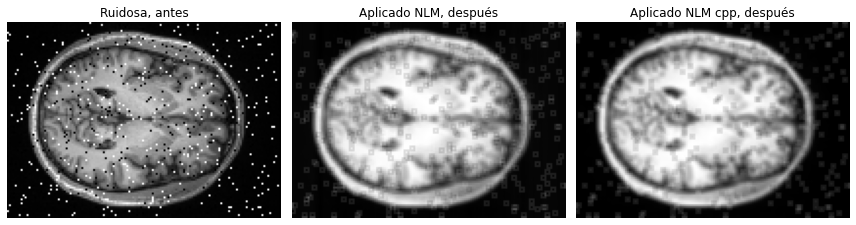

In [21]:
fig = plt.figure(figsize=(12,11))
plt.subplot(131)
plt.imshow(img_salpimienta,cmap=plt.cm.gray)
plt.title('Ruidosa, antes'), plt.axis('off')
plt.subplot(132)
plt.title('Aplicado NLM, después'), plt.axis('off')
plt.imshow(nlm_sal, cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Aplicado NLM cpp, después'), plt.axis('off')
plt.imshow(nlm_cpp1, cmap=plt.cm.gray)
# Adjust subplot parameters to give specified padding
plt.tight_layout()

En el caso de NLM-CPP queremos que los píxeles de mayor intensidad no se pierdan completamente en el filtrado. Con las imagenes anteriores podemos ver que el gris de los píxeles de "sal" de la imagen original no se pierden por completo. 

In [22]:
a, b, c = funciones.all_filters(img_gauss4, 0.7, 0.7, 0.7, 5, 5)
x, y, z = funciones.all_filters(img_salpimienta4, 5, 5, 5, 10, 10)

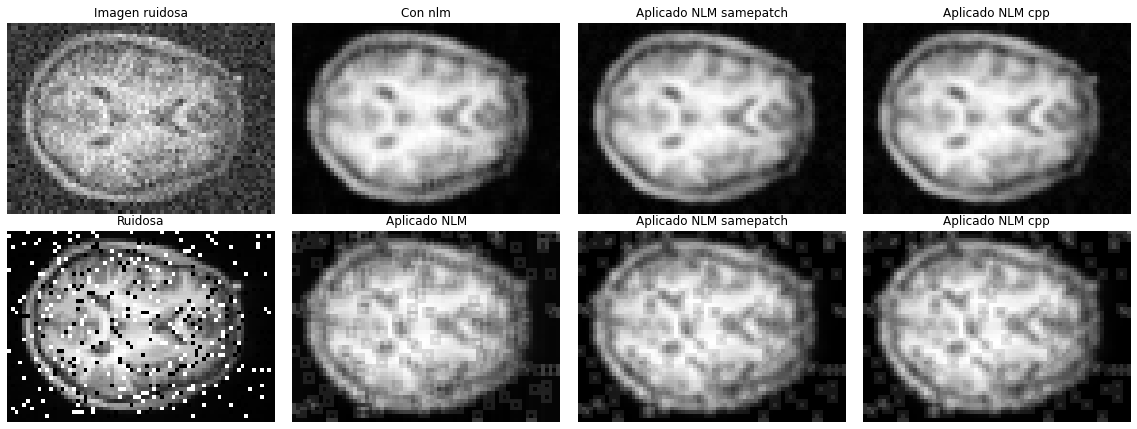

In [23]:
fig = plt.figure(figsize=(16,6))
plt.subplot(241)
plt.imshow(img_gauss4,cmap=plt.cm.gray)
plt.title('Imagen ruidosa'), plt.axis('off')
plt.subplot(242)
plt.imshow(a,cmap=plt.cm.gray)
plt.title('Con nlm'), plt.axis('off')
plt.subplot(243)
plt.title('Aplicado NLM samepatch'), plt.axis('off')
plt.imshow(b, cmap=plt.cm.gray)
plt.subplot(244)
plt.title('Aplicado NLM cpp'), plt.axis('off')
plt.imshow(c, cmap=plt.cm.gray)

plt.subplot(245)
plt.imshow(img_salpimienta4,cmap=plt.cm.gray)
plt.title('Ruidosa'), plt.axis('off')
plt.subplot(246)
plt.title('Aplicado NLM'), plt.axis('off')
plt.imshow(x, cmap=plt.cm.gray)
plt.subplot(247)
plt.title('Aplicado NLM samepatch'), plt.axis('off')
plt.imshow(y, cmap=plt.cm.gray)
plt.subplot(248)
plt.title('Aplicado NLM cpp'), plt.axis('off')
plt.imshow(z, cmap=plt.cm.gray)
# Adjust subplot parameters to give specified padding
plt.tight_layout() 

Cuando queremos filtrar imágenes con partículas de alto contraste en ellas que pueden contener información valiosa es recomentable usar este filtrado. Esta diferencia de intensidad es significativamente mayor que la causada por el ruido, lo que solventamos con este método CPP evitando el completo suavizado del algoritmo NLM simple.

En definitiva, esta modificación de NLM, nos permite obtener más información de la imagen. 



## Resultados finales

Vamos a comparar nuestro último resultado de NLM-CPP con el resultado que arroja la función **.denoise_nl_means()** del paquete **skimage.restoration**.

In [26]:
img_pad = np.pad(img_salpimienta,1, mode='reflect')
denoise_img = skimage.restoration.denoise_nl_means(img_salpimienta, patch_size=3, h = 0.2)
nlm_cppfin =  modules.nlm_cpp(img_salpimienta, img_pad, 5, 1, 1)

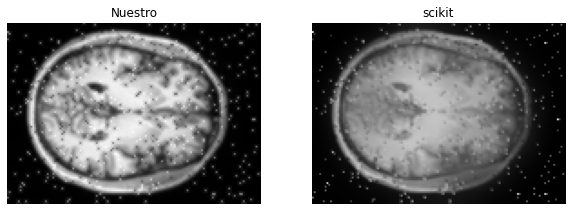

In [27]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(nlm_cppfin,cmap=plt.cm.gray)
plt.title('Nuestro'), plt.axis('off')
plt.subplot(122)
plt.title('scikit'), plt.axis('off')
plt.imshow(denoise_img, cmap=plt.cm.gray)

Como vemos en este apartado de comprobación, se enfatizan más las zonas no homogéneas. Se puede confirmar que los puntos brillantes no se suavizan completamente con nuestro algoritmo en las mismas zonas que en el caso de prueba con el paquete **scikit**.

Como en el editor de Código Spyder se obtienen unos resultados visuales de mejor calidad, hemos decidido incluir la siguiente imagen para poder discernir con claridad los efectos de cada de los algoritmos implementados.

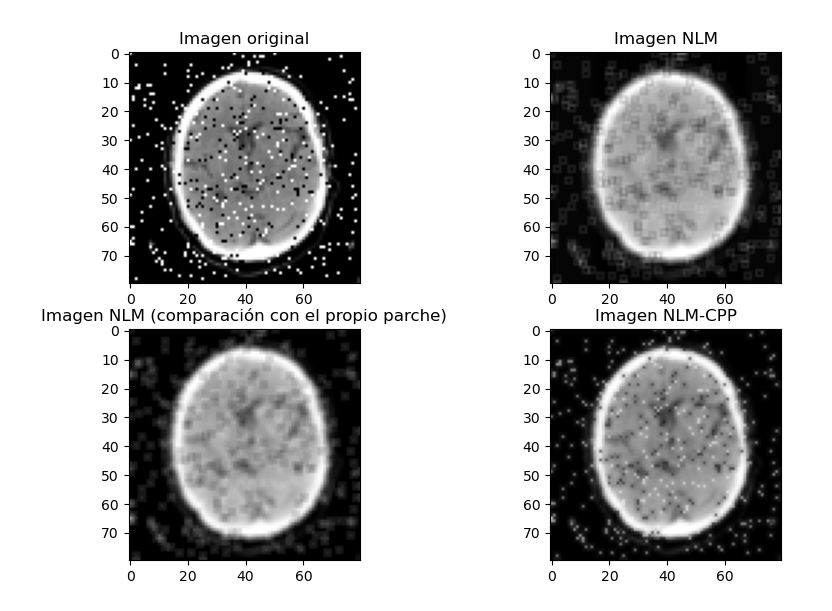

En esta imagen de prueba (que no forma parte de nuestra base de datos) proporcionada por el profesor, observamos claramente que los resultados concuerdan con los obtenidos en nuestro análisis anterior.

En la imagen final con filtrado NLM-CPP se nota una clara mejoría en la conservación de píxeles de intensidades mayores, evitando así suavizar posibles indicios de lesión.

## Referencias

Consideramos útil remarcar la lectura del siguiente paper, que nos ha ayudado a comprender mejor el significado de los parámetros de los algoritmos NLM:

**Denoising MR Images Using Non-Local Means Filter withCombined Patch and Pixel Similarity** Xinyuan Zhang, Guirong Hou, Jianhua Ma, Wei Yang, Bingquan Lin, Yikai Xu, Wufan Chen,Yanqiu Feng
https://www.researchgate.net/publication/263130330_Denoising_MR_Images_Using_Non-Local_Means_Filter_with_Combined_Patch_and_Pixel_Similarity